# Знакомство с данными и агрегация

In [31]:
import pandas as pd
import calendar
from datetime import date, datetime, timedelta
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

В каждом из файлов содержится следующая информация о поездках:

| Code | Value   |
|------|------|
|tpep_pickup_datetime | время начала поездки|
|tpep_dropoff_datetime | время окончания поездки|
|pickup_longitude pickup_latitude | долгота и широта точки начала поездки|
|dropoff_longitude dropoff_latitude | долгота и широта точки окончания поездки|
|passenger_count | количество пассажиров|
|trip_distance | расстояние по счётчику|
|RatecodeID | тип тарифа (одна из шести категорий)|
|payment_type | способ оплаты (одна из шести категорий)|
|fare_amount | стоимость поездки по счётчику|
|extra | налог на счётчик|
|mta_tax | доплата за поездки в пиковые часы и ночью|
|tolls_amount | доплата за проезд по платным дорогам|
|improvement_surcharge | доплата за проезд, взимаемая с каждой поездки с января 2015|
|tip_amount | размер чаевых|
|total_amount | общая стоимость поездки|
|VendorID | провайдер данных (одна из двух категорий)|
|store_and_fwd_flag | бинарный флаг, показывающий, были ли данные о поезде получены немедленно после её окончания, или какое-то время хранились в памяти автомобиля.|



In [32]:
# Загрузим регионы
regions=pd.read_csv('regions.csv',sep=';')
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


## Загрузим данные за май 2016 года

In [4]:
curyear='2016'
curmonth='05'
data=pd.read_csv('D:/Загрузки/yellow_tripdata_'+curyear+'-'+curmonth+'.csv')
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


## Проведим фильтрацию данных

In [33]:
# Функция выполняет фильтрацию переданного датасета, удаляя бесполезные данные о поездках
def filter_trips(data):
    # Оставляем поездки с ненулевой длительностью
    fil=((data.tpep_dropoff_datetime>data.tpep_pickup_datetime)&
    # Оставляем поездки с ненулевым количеством пассажиров
    (data.passenger_count>0)& 
    # Оставляем поездки с ненулевым расстоянием поездки по счётчику
    (data.trip_distance>0)& 
    # Оставляем поездки с координатами начала, попадающими в прямоугольник Нью-Йорка
    #  от -74.25559 до -73.70001 градусов долготы
    # от 40.49612 до 40.91553 широты.
    (data.pickup_longitude>=-74.25559)&(data.pickup_longitude<=-73.70001)&(data.pickup_latitude>=40.49612)&(data.pickup_latitude<=40.91553))
    return data[fil]

In [6]:
# Применяем фильтр
data=filter_trips(data)
data.shape

(11626521, 19)

## Агрегируем данные за месяц по часам и областям 

In [34]:
# Функция преобразует координаты в номер региона
def coord_to_region(latitude,longitude):
    def normalize_longitude(longitude):
        lo_step=0.011111600000000124
        lo_min=-74.255589999999998
        return np.floor((longitude-lo_min)/lo_step)
    def normalize_latitude(latitude):
        la_step=0.008388199999999983
        la_min= 40.496119999999998
        return np.floor((latitude-la_min)/la_step)
    return normalize_latitude(latitude)+50*normalize_longitude(longitude)

In [35]:
# Функция преобразует дату к числовому виду yyyymmddhh для дальнейшего использования при агрегации 
def datetime_to_int(dt):
    return 1000000*dt.year + 10000*dt.month + 100*dt.day+dt.hour

# Функция формирует перечень дат в числовом виде yyyymmddhh за период с первое по последнее число 
# месяца month в году year с шагом 1 час
def gen_range(year,month,adddays,addhours):
    def perdelta(start, end, delta):
        curr = start
        while curr < end:
            yield curr
            curr += delta
    last_day= datetime(year,month,calendar.monthrange(year,month)[1])+timedelta(days=adddays,hours=addhours)
    datetime_range=[]  
    for result in perdelta(datetime(year, month, 1), last_day, timedelta(hours=1)):
        datetime_range.append(datetime_to_int(result))
    return datetime_range

In [45]:
# Фуникция вычисляет агрегированные данные по часу и региону посадки
def get_arg_data(data,year,month):
    # Преобразовываем тип колонок к типу дата
    data.tpep_pickup_datetime= pd.to_datetime(data.tpep_pickup_datetime)
    data.tpep_dropoff_datetime= pd.to_datetime(data.tpep_dropoff_datetime)
    # Строим новую колонку - час посадки                           
    data['z_tpep_pickup_hour']=data.tpep_pickup_datetime.apply(datetime_to_int)
    # Вычисляем регион посадки                                          
    data['z_region_id']=coord_to_region(data.pickup_latitude,data.pickup_longitude)
    # Строим таблицу Час-Регион. В ячейках таблице количество посадок в такси за данный час в данном регионе                                           
    binx = gen_range(int(year),int(month),1,1)
    biny=np.append(regions.region.values,regions.region.values.max()+1)
    ret=stats.binned_statistic_2d(data.z_tpep_pickup_hour.values,data.z_region_id.values,None, 'count', bins=[binx,biny])
    # Преобразуем индекс к дате
    df=pd.DataFrame(ret.statistic,index=gen_range(int(year),int(month),1,0),columns=regions.region.values)                                           
    df.index=df.index.map(lambda x:datetime.strptime(str(x), "%Y%m%d%H"))
    df.index.names = ['dt']
    # Возвращем полученную таблицу
    return df

In [57]:
# Выполняем агрегацию
agr_data=get_arg_data(data,curyear,curmonth)
agr_data.to_csv('arg_data_may.csv',sep=';')

KeyboardInterrupt: 

## Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

In [33]:
agr_data.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
dt,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

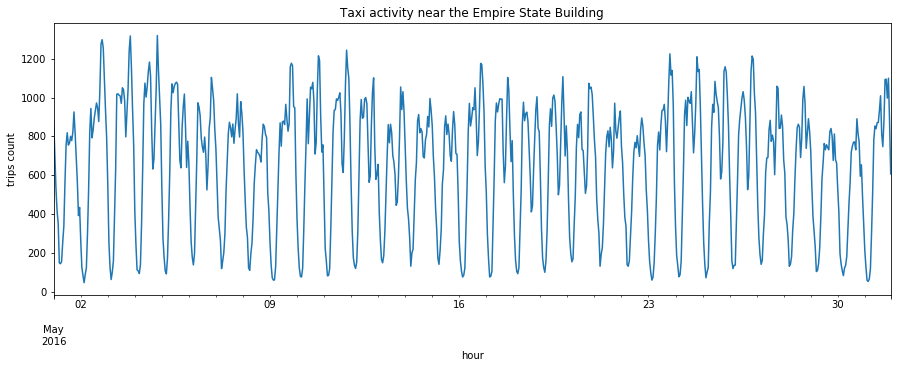

In [32]:
# Коррдинаты и регион ESB
esb_latitude = 40.748817
esb_longitude = -73.985428
esb_region=coord_to_region(esb_latitude,esb_longitude)
# Строим график
plt.figure(figsize=[15,5])
agr_data[esb_region].plot()
plt.title('Taxi activity near the Empire State Building')
plt.xlabel('hour')
plt.ylabel('trips count')
plt.show()

## Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [34]:
(agr_data==0).sum().sum()

1718238

# Формируем агрегированные данные за период (полгода)

In [37]:
def get_agr(year,month):
    data=pd.read_csv('D:/Загрузки/yellow_tripdata_'+year+'-'+month+'.csv')
    data=filter_trips(data)
    agr_data=get_arg_data(data,year,month)
    return agr_data

In [49]:
arg_data=pd.DataFrame()
for year in ['2016']:
    for month in ['01','02','03','04','05']:
        arg_data=pd.concat([arg_data,get_agr(year,month)])
arg_data.shape

(3648, 2500)

In [50]:
arg_data.to_csv('arg_data.csv',sep=';')